In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os, sys
import argparse
import torch

from Code.Utils import from_pickle
from Code.models import acrobot
from Code.integrate_models import implicit_integration_DEL, integrate_ODE
from Code.symo import SyMo_T
from Code.NN import LODE_T, NODE_T


THIS_DIR = os.getcwd()


In [2]:
DPI = 100
FORMAT = 'png'
LINE_SEGMENTS = 10
ARROW_SCALE = 60
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
save_dir = "Experiments_acrobot/h=0.05"

def get_args():
    return {'fig_dir': './figures/acrobot',
            'gpu': 2,
            'pred_tol': 1e-5 ,
            'pred_maxiter': 10}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

args = ObjectView(get_args())

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

def get_model(model, submodel, device):
    path = '{}/{}/{}{}-p-{}-stats.pkl'.format(THIS_DIR, save_dir, "acrobot-", model, submodel)
    stats = from_pickle(path)
    args = argparse.Namespace(**stats['hyperparameters'])
    
    if model == 'N-SyMo' or model== 'SyMo':
        nn = SyMo_T(args.num_angles, args.n_hidden_layers, args.n_neurons, args.time_step, args.nonlinearity).to(device).eval()
        path = '{}/{}/{}{}-p-{}.tar'.format(THIS_DIR, save_dir, "acrobot-", model, submodel)
        nn.load_state_dict(torch.load(path, map_location=device))
    
    elif 'L-NODE' in model:
        nn = LODE_T(args.num_angles, args.n_hidden_layers, args.n_neurons, args.nonlinearity).to(device).eval()
        path = '{}/{}/{}{}-p-{}.tar'.format(THIS_DIR, save_dir, "acrobot-", model, submodel)
        nn.load_state_dict(torch.load(path, map_location=device))

    elif 'NODE' in model:
        nn = NODE_T(args.num_angles, args.n_hidden_layers, args.n_neurons, args.nonlinearity, 1).to(device).eval()
        path = '{}/{}/{}{}-p-{}.tar'.format(THIS_DIR, save_dir, "acrobot-", model, submodel)
        nn.load_state_dict(torch.load(path, map_location=device))
    return nn, stats, args


In [3]:
models = ['8x32', '16x32', "32x32", "64x32", "128x32"]

def load_stats(nn, models):
    #loads the stats of all models
    train_loss = []
    test_loss= []
    int_loss = []
    int_std = []
    E_loss = []
    E_std = []
    H_loss = []
    H_std = []
    for model in models:
        path = '{}/{}/{}{}-p-{}-stats.pkl'.format(THIS_DIR, save_dir, "acrobot-", nn, model)
        stats = from_pickle(path)
        if 'SyMo' in nn:
            train_loss.append(stats['train_loss_poses'])
            test_loss.append(stats['test_loss_poses'])
        else:
            train_loss.append(stats['train_loss_poses'])
            test_loss.append(stats['test_loss_poses'])
        
        int_loss.append(stats['int_loss_poses'])
        int_std.append(stats['int_std'])
        E_loss.append(stats['E_loss'])
        E_std.append(stats['E_std'])
        if nn != 'NODE-rk4' and nn != "NODE-midpoint":
            H_loss.append(stats['H_loss'])
            H_std.append(stats['H_std'])
    if nn != 'NODE-rk4' and nn != "NODE-midpoint":
        return train_loss, test_loss, int_loss, int_std, E_loss, E_std, H_loss, H_std
    else:
        return train_loss, test_loss, int_loss, int_std, E_loss, E_std

#Load E2E-SyMo models
train_loss_N_SYMO, test_loss_N_SYMO, int_loss_N_SYMO, int_std_N_SYMO, E_loss_N_SYMO, E_std_N_SYMO, H_loss_N_SYMO, H_std_N_SYMO = load_stats('N-SyMo', models)
# Load SyMo models
train_loss_SYMO, test_loss_SYMO, int_loss_SYMO, int_std_SYMO, E_loss_SYMO, E_std_SYMO, H_loss_SYMO, H_std_SYMO = load_stats('SyMo', models)
#Load LODE_RK4 models
train_loss_LODE_RK4, test_loss_LODE_RK4, int_loss_LODE_RK4, int_std_LODE_RK4, E_loss_LODE_RK4, E_std_LODE_RK4, H_loss_LODE_RK4, H_std_LODE_RK4 = load_stats('L-NODE-rk4', models)
#Load LODE_RK2 models
train_loss_LODE_RK2, test_loss_LODE_RK2, int_loss_LODE_RK2, int_std_LODE_RK2, E_loss_LODE_RK2, E_std_LODE_RK2, H_loss_LODE_RK2, H_std_LODE_RK2 = load_stats('L-NODE-midpoint', models)
#Load NODE_RK4 models
train_loss_NODE_RK4, test_loss_NODE_RK4, int_loss_NODE_RK4, int_std_NODE_RK4, E_loss_NODE_RK4, E_std_NODE_RK4 = load_stats('NODE-rk4', models)
#Load NODE_RK2 models
train_loss_NODE_RK2, test_loss_NODE_RK2, int_loss_NODE_RK2, int_std_NODE_RK2, E_loss_NODE_RK2, E_std_NODE_RK2 = load_stats('NODE-midpoint', models)


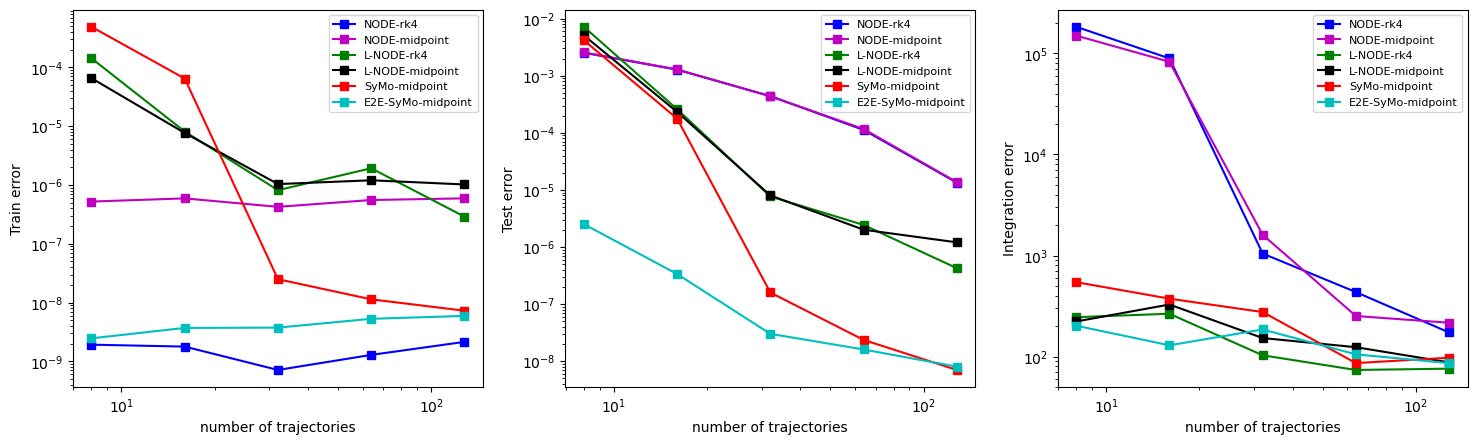

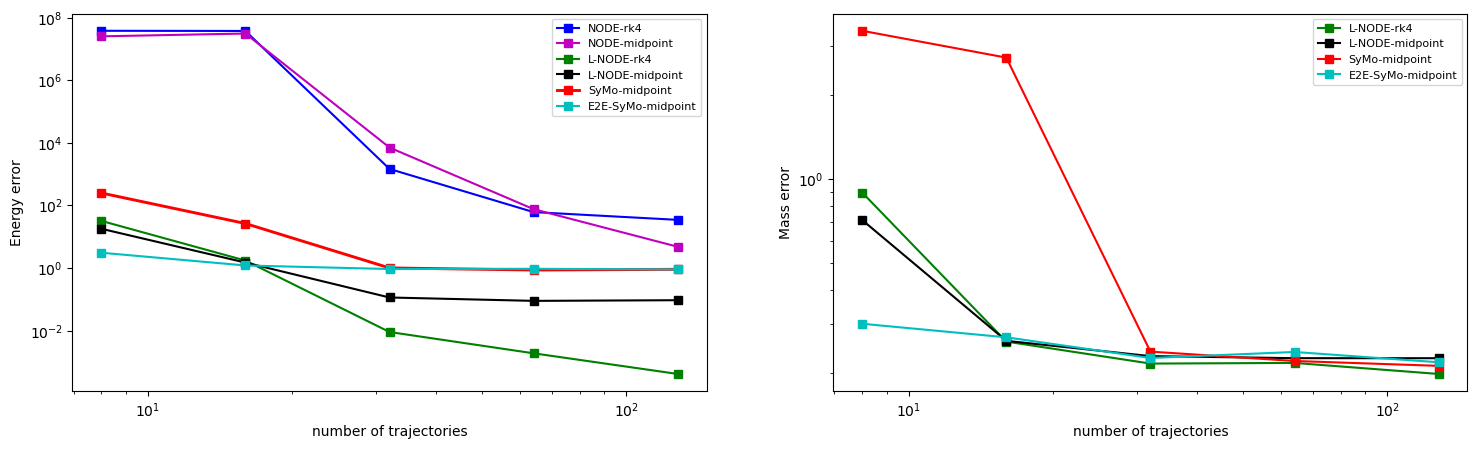

In [4]:
x_axis = np.array([8, 16, 32, 64, 128])

fig = plt.figure(figsize=(18, 5), dpi=DPI)
plt.subplot(1, 3, 1)
plt.plot(x_axis, train_loss_NODE_RK4, 'bs-', label='NODE-rk4')
plt.plot(x_axis, train_loss_NODE_RK2, 'ms-', label='NODE-midpoint')
plt.plot(x_axis, train_loss_LODE_RK4, 'gs-', label= 'L-NODE-rk4')
plt.plot(x_axis, train_loss_LODE_RK2, 'ks-', label='L-NODE-midpoint')
plt.plot(x_axis, train_loss_SYMO, 'rs-', label='SyMo-midpoint')
plt.plot(x_axis, train_loss_N_SYMO, 'cs-', label  = 'E2E-SyMo-midpoint')
plt.xscale('log')
plt.yscale('log')
# plt.xlabel('number of state initial condition')
plt.ylabel('Train error')
plt.xlabel('number of trajectories')
plt.legend(fontsize=8)

plt.subplot(1, 3, 2)
plt.plot(x_axis, test_loss_NODE_RK4, 'bs-', label='NODE-rk4')
plt.plot(x_axis, test_loss_NODE_RK2, 'ms-', label='NODE-midpoint')
plt.plot(x_axis, test_loss_LODE_RK4, 'gs-', label= 'L-NODE-rk4')
plt.plot(x_axis, test_loss_LODE_RK2, 'ks-', label='L-NODE-midpoint')
plt.plot(x_axis, test_loss_SYMO, 'rs-', label='SyMo-midpoint')
plt.plot(x_axis, test_loss_N_SYMO, 'cs-', label  = 'E2E-SyMo-midpoint')
plt.xscale('log')
plt.yscale('log')
# plt.xlabel('number of state initial condition')
plt.xlabel('number of trajectories')
plt.ylabel('Test error')
plt.legend(fontsize=8)

plt.subplot(1, 3, 3)
plt.plot(x_axis, int_loss_NODE_RK4, 'bs-', label='NODE-rk4')
plt.plot(x_axis, int_loss_NODE_RK2, 'ms-', label='NODE-midpoint')
plt.plot(x_axis, int_loss_LODE_RK4, 'gs-', label= 'L-NODE-rk4')
plt.plot(x_axis, int_loss_LODE_RK2, 'ks-', label='L-NODE-midpoint')
plt.plot(x_axis, int_loss_SYMO, 'rs-', label='SyMo-midpoint')
plt.plot(x_axis, int_loss_N_SYMO, 'cs-', label  = 'E2E-SyMo-midpoint')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of trajectories')
plt.ylabel('Integration error')
plt.legend(fontsize=8)

fig.savefig('{}/fig-train-pred-loss_acrobot.{}'.format(args.fig_dir, FORMAT))

fig = plt.figure(figsize=(18, 5), dpi=DPI)
plt.subplot(1, 2, 1)
plt.plot(x_axis, E_loss_NODE_RK4, 'bs-', label='NODE-rk4')
plt.plot(x_axis, E_loss_NODE_RK2, 'ms-', label='NODE-midpoint')
plt.plot(x_axis, E_loss_LODE_RK4, 'gs-', label= 'L-NODE-rk4')
plt.plot(x_axis, E_loss_LODE_RK2, 'ks-', label='L-NODE-midpoint')
plt.plot(x_axis, E_loss_SYMO, 'rs-', label='SyMo-midpoint', linewidth=2.1)
plt.plot(x_axis, E_loss_N_SYMO, 'cs-', label  = 'E2E-SyMo-midpoint')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=8)
# plt.xlabel('number of state initial condition')
plt.ylabel('Energy error')
plt.xlabel('number of trajectories')
plt.legend(fontsize=8)

plt.subplot(1, 2, 2)
plt.plot(x_axis, H_loss_LODE_RK4, 'gs-', label= 'L-NODE-rk4')
plt.plot(x_axis, H_loss_LODE_RK2, 'ks-', label='L-NODE-midpoint')
plt.plot(x_axis, H_loss_SYMO, 'rs-', label='SyMo-midpoint')
plt.plot(x_axis, H_loss_N_SYMO, 'cs-', label  = 'E2E-SyMo-midpoint')
plt.xscale('log')
plt.yscale('log')
# plt.xlabel('number of state initial condition')
plt.ylabel('Mass error')
plt.xlabel('number of trajectories')
plt.legend(fontsize=8)

fig.savefig('{}/fig-energy_inertia_acrobot.{}'.format(args.fig_dir, FORMAT))


# Analyse Moderate Regime Data Models

In [5]:
model = "32x32"
nn_symo, stats_symo, args_symo = get_model('SyMo', model, device)
nn_e2e_symo, stats_e2e_symo, args_e2e_symo = get_model('N-SyMo', model, device)
nn_lode_rk2, stats_lode_rk2, args_lode_rk2 = get_model('L-NODE-midpoint', model, device)
nn_lode_rk4, stats_lode_rk4, args_lode_rk4 = get_model('L-NODE-rk4', model, device)
nn_node_rk2, stats_node_rk2, args_node_rk2 = get_model('NODE-midpoint', model, device)
nn_node_rk4, stats_node_rk4, args_node_rk4 = get_model('NODE-rk4', model, device)

print('NODE-Midpoint')
print("Train Loss {:.4e}: Test Loss:{:.4e} Integration_loss: {:.4e} +/- {:.4e} Energy Loss:{:.4e} +/- {:.4e}".format(stats_node_rk2['train_loss_poses'], stats_node_rk2['test_loss_poses'], stats_node_rk2['int_loss_poses'], stats_node_rk2['int_std'], stats_node_rk2['E_loss'], stats_node_rk2['E_std']))
print('')
print('NODE-RK4')
print("Train Loss {:.4e}: Test Loss:{:.4e} Integration_loss: {:.4e} +/- {:.4e} Energy Loss:{:.4e} +/- {:.4e}".format(stats_node_rk4['train_loss_poses'], stats_node_rk4['test_loss_poses'], stats_node_rk4['int_loss_poses'], stats_node_rk4['int_std'], stats_node_rk4['E_loss'], stats_node_rk4['E_std']))
print('')
print('L-NODE-Midpoint')
print("Train Loss {:.4e}: Test Loss:{:.4e} Integration_loss: {:.4e} +/- {:.4e} Energy Loss:{:.4e} +/- {:.4e} Inertia Loss:{:.4e} +/- {:.4e}".format(stats_lode_rk2['train_loss_poses'], stats_lode_rk2['test_loss_poses'], stats_lode_rk2['int_loss_poses'], stats_lode_rk2['int_std'], stats_lode_rk2['E_loss'], stats_lode_rk2['E_std'], stats_lode_rk2['H_loss'], stats_lode_rk2['H_std']))
print('')
print('L-NODE-RK4')
print("Train Loss {:.4e}: Test Loss:{:.4e} Integration_loss: {:.4e} +/- {:.4e} Energy Loss:{:.4e} +/- {:.4e} Inertia Loss:{:.4e} +/- {:.4e}".format(stats_lode_rk4['train_loss_poses'], stats_lode_rk4['test_loss_poses'], stats_lode_rk4['int_loss_poses'], stats_lode_rk4['int_std'], stats_lode_rk4['E_loss'], stats_lode_rk4['E_std'], stats_lode_rk4['H_loss'], stats_lode_rk4['H_std']))
print('')
print('SyMo')
print("Train Loss {:.4e}: Test Loss:{:.4e} Integration_loss: {:.4e} +/- {:.4e} Energy Loss:{:.4e} +/- {:.4e} Inertia Loss:{:.4e} +/- {:.4e}".format(stats_symo['train_loss_poses'], stats_symo['test_loss_poses'], stats_symo['int_loss_poses'], stats_symo['int_std'], stats_symo['E_loss'], stats_symo['E_std'], stats_symo['H_loss'], stats_symo['H_std']))
print('')
print('E2E-SyMo')
print("Train Loss {:.4e}: Test Loss:{:.4e} Integration_loss: {:.4e} +/- {:.4e} Energy Loss:{:.4e} +/- {:.4e} Inertia Loss:{:.4e} +/- {:.4e}".format(stats_e2e_symo['train_loss_poses'], stats_e2e_symo['test_loss_poses'], stats_e2e_symo['int_loss_poses'], stats_e2e_symo['int_std'], stats_e2e_symo['E_loss'], stats_e2e_symo['E_std'], stats_e2e_symo['H_loss'], stats_e2e_symo['H_std']))
print('')


NODE-Midpoint
Train Loss 4.2456e-07: Test Loss:4.3607e-04 Integration_loss: 1.6048e+03 +/- 2.5113e+03 Energy Loss:7.0463e+03 +/- 2.6368e+04

NODE-RK4
Train Loss 7.1437e-10: Test Loss:4.3907e-04 Integration_loss: 1.0464e+03 +/- 1.5403e+03 Energy Loss:1.4588e+03 +/- 5.0271e+03

L-NODE-Midpoint
Train Loss 1.0354e-06: Test Loss:8.0094e-06 Integration_loss: 1.5263e+02 +/- 2.5476e+02 Energy Loss:1.1431e-01 +/- 1.2759e-01 Inertia Loss:2.3058e-01 +/- 8.1106e-02

L-NODE-RK4
Train Loss 8.1558e-07: Test Loss:7.6987e-06 Integration_loss: 1.0300e+02 +/- 1.1596e+02 Energy Loss:9.0311e-03 +/- 1.1580e-02 Inertia Loss:2.1675e-01 +/- 8.0368e-02

SyMo
Train Loss 2.4970e-08: Test Loss:1.6021e-07 Integration_loss: 2.7577e+02 +/- 6.8289e+02 Energy Loss:1.0027e+00 +/- 7.5390e-01 Inertia Loss:2.3932e-01 +/- 8.6346e-02

E2E-SyMo
Train Loss 3.7499e-09: Test Loss:3.0257e-08 Integration_loss: 1.8541e+02 +/- 3.0776e+02 Energy Loss:9.2732e-01 +/- 7.0789e-01 Inertia Loss:2.2702e-01 +/- 8.3299e-02



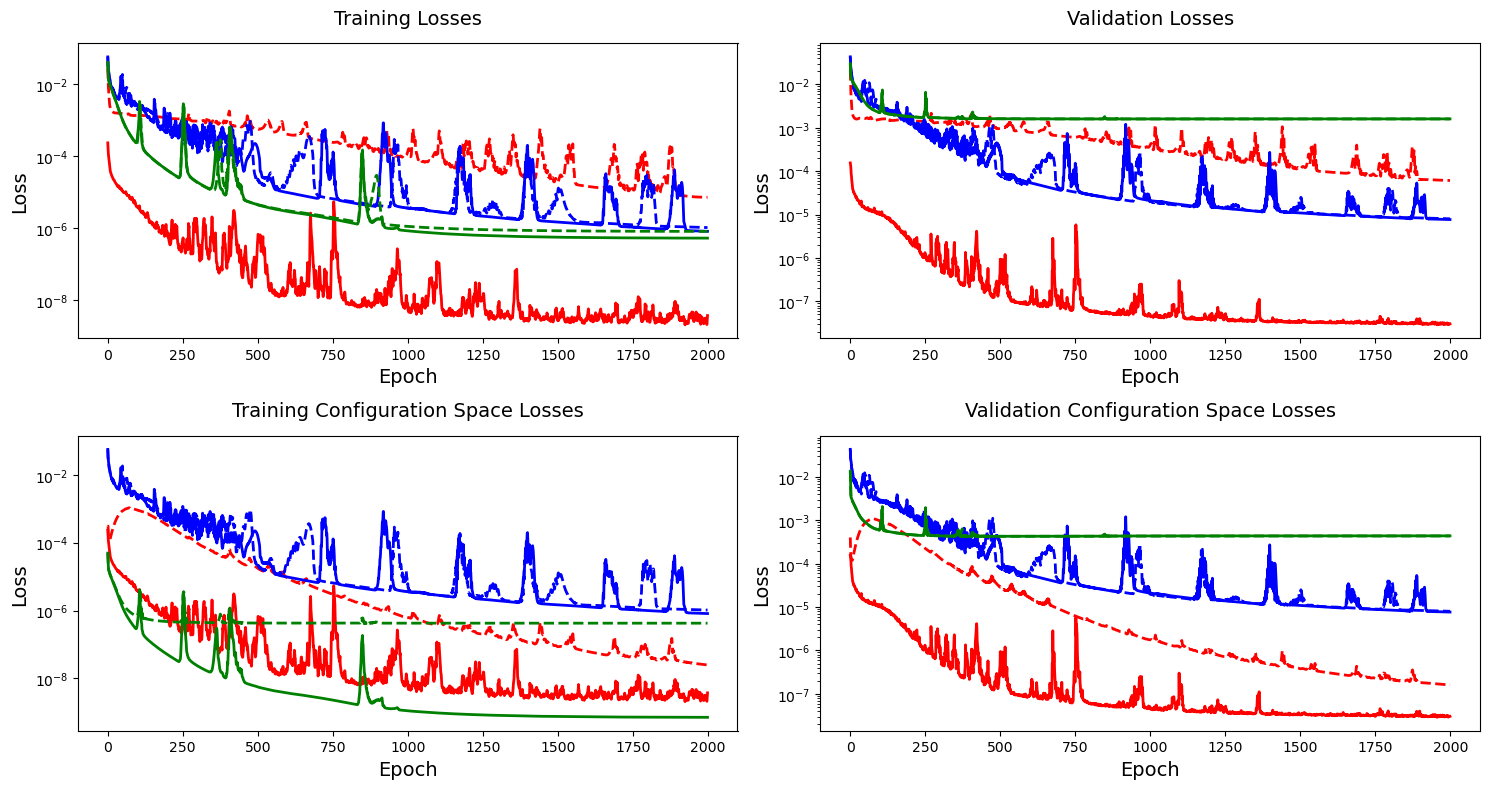

In [6]:
#get learning args
train_args = argparse.Namespace(**stats_symo['hyperparameters'])
#%% Training/Test losses and aditional information
fig = plt.figure(figsize=(15, 8), dpi=DPI)
plt.subplot(2, 2, 1)

plt.plot(stats_e2e_symo['train_losses'], 'r-', label='E2E-SyMo', linewidth=2)
plt.plot(stats_symo['train_losses'], 'r--', label='SyMo', linewidth=2)
plt.plot(stats_lode_rk2['train_losses'], 'b--', label='L-NODE-Midpoint', linewidth=2)
plt.plot(stats_lode_rk4['train_losses'], 'b-', label='L-NODE-RK4', linewidth=2)
plt.plot(stats_node_rk2['train_losses'], 'g--', label='NODE-Midpoint', linewidth=2)
plt.plot(stats_node_rk4['train_losses'], 'g-', label='NODE-RK4', linewidth=2)
plt.title("Training Losses", pad=14, fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.yscale('log')
plt.subplot(2, 2, 2)

plt.plot(stats_e2e_symo['test_losses'], 'r-', label='E2E-SyMo', linewidth=2)
plt.plot(stats_symo['test_losses'], 'r--', label='SyMo', linewidth=2)
plt.plot(stats_lode_rk2['test_losses'], 'b--', label='L-NODE-Midpoint', linewidth=2)
plt.plot(stats_lode_rk4['test_losses'], 'b-', label='L-NODE-RK4', linewidth=2)
plt.plot(stats_node_rk2['test_losses'], 'g--', label='NODE-Midpoint', linewidth=2)
plt.plot(stats_node_rk4['test_losses'], 'g-', label='NODE-RK4', linewidth=2)
plt.title("Validation Losses", pad=14, fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.yscale('log')

plt.subplot(2, 2, 3)
plt.plot(stats_e2e_symo['train_losses_poses'], 'r-', label='E2E-SyMo', linewidth=2)
plt.plot(stats_symo['train_losses_poses'], 'r--', label='SyMo', linewidth=2)
plt.plot(stats_lode_rk2['train_losses_poses'], 'b--', label='L-NODE-Midpoint', linewidth=2)
plt.plot(stats_lode_rk4['train_losses_poses'], 'b-', label='L-NODE-RK4', linewidth=2)
plt.plot(stats_node_rk2['train_losses_poses'], 'g--', label='NODE-Midpoint', linewidth=2)
plt.plot(stats_node_rk4['train_losses_poses'], 'g-', label='NODE-RK4', linewidth=2)
plt.title("Training Configuration Space Losses", pad=14, fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.yscale('log')

plt.subplot(2, 2, 4)
plt.plot(stats_e2e_symo['test_losses_poses'], 'r-', label='E2E-SyMo', linewidth=2)
plt.plot(stats_symo['test_losses_poses'], 'r--', label='SyMo', linewidth=2)
plt.plot(stats_lode_rk2['test_losses_poses'], 'b--', label='L-NODE-Midpoint', linewidth=2)
plt.plot(stats_lode_rk4['test_losses_poses'], 'b-', label='L-NODE-RK4', linewidth=2)
plt.plot(stats_node_rk2['test_losses_poses'], 'g--', label='NODE-Midpoint', linewidth=2)
plt.plot(stats_node_rk4['test_losses_poses'], 'g-', label='NODE-RK4', linewidth=2)
plt.title("Validation Configuration Space Losses", pad=14, fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.yscale('log')
fig.tight_layout()
plt.savefig('{}/losses_acrobot'.format(args.fig_dir, 'png'))

In [7]:
#%% Integrate models and plot
x0 = [0, np.pi/2,0, 0] 

h=args_symo.time_step #all models were trained under the same time_step
N=500
u = np.zeros(shape=(N +2))
t_eval = np.linspace(0, (N+1)*h , N+2)
import gym 
import Code.myenv
#get ground truth
env = gym.make('MyAcrobot-v0')
env.dt = args_symo.time_step
env.state = np.array(x0, dtype=np.float32)
obs_list = []
obs_list.append(env.state)

for i in range(len(t_eval)):
    obs, _, _, _ = env.step([u[i]])
    obs_list.append(obs)
traj = np.stack(obs_list)

x_true = traj
y_true = traj[2:]

x0_odes = torch.tensor(x_true[1]).float().to(device)
x0_symos = torch.tensor(x_true[:2, :2].flatten()).float().to(device)

x_gt = torch.tensor(x_true[1:])
y_gt = torch.tensor(y_true[:-1])

y_pred_node_midpoint = integrate_ODE(nn_node_rk2, "midpoint", x0_odes, N, h, device)
y_pred_node_rk4 = integrate_ODE(nn_node_rk4, "rk4", x0_odes, N, h, device)
y_pred_lode_midpoint = integrate_ODE(nn_lode_rk2, "midpoint", x0_odes, N, h, device)
y_pred_lode_rk4 = integrate_ODE(nn_lode_rk4, "rk4", x0_odes, N, h, device)

#Integrate models symos
y_pred_symo = implicit_integration_DEL(args_symo.root_find, N, h, nn_symo, x0_symos, args.pred_tol, args.pred_maxiter, device, us = None)
y_pred_e2e_symo = implicit_integration_DEL(args_e2e_symo.root_find, N, h, nn_e2e_symo, x0_symos, args.pred_tol, args.pred_maxiter, device, us = None)
#get true quantities
V_true = acrobot().potential_energy(y_gt)
T_true = acrobot().kinetic_energy(y_gt)
True_E = torch.ones_like(T_true)*acrobot().energy(np.array([x0]))
#Learned quantities
H_learned_lode_midpoint, V_learned_lode_midpoint, T_learned_lode_midpoint = nn_lode_rk2.get_matrices(y_pred_lode_midpoint) 
H_learned_lode_rk4, V_learned_lode_rk4, T_learned_lode_rk4 = nn_lode_rk4.get_matrices(y_pred_lode_rk4) 
H_learned_symo, V_learned_symo, T_learned_symo = nn_symo.get_matrices(y_pred_symo) 
H_learned_e2e_symo, V_learned_e2e_symo, T_learned_e2e_symo = nn_e2e_symo.get_matrices(y_pred_e2e_symo) 

E_learned_lode_midpoint = T_learned_lode_midpoint + V_learned_lode_midpoint
E_learned_lode_rk4 = T_learned_lode_rk4 + V_learned_lode_rk4
E_learned_symo = T_learned_symo + V_learned_symo
E_learned_e2e_symo = T_learned_e2e_symo + V_learned_e2e_symo


## Learned Quantities

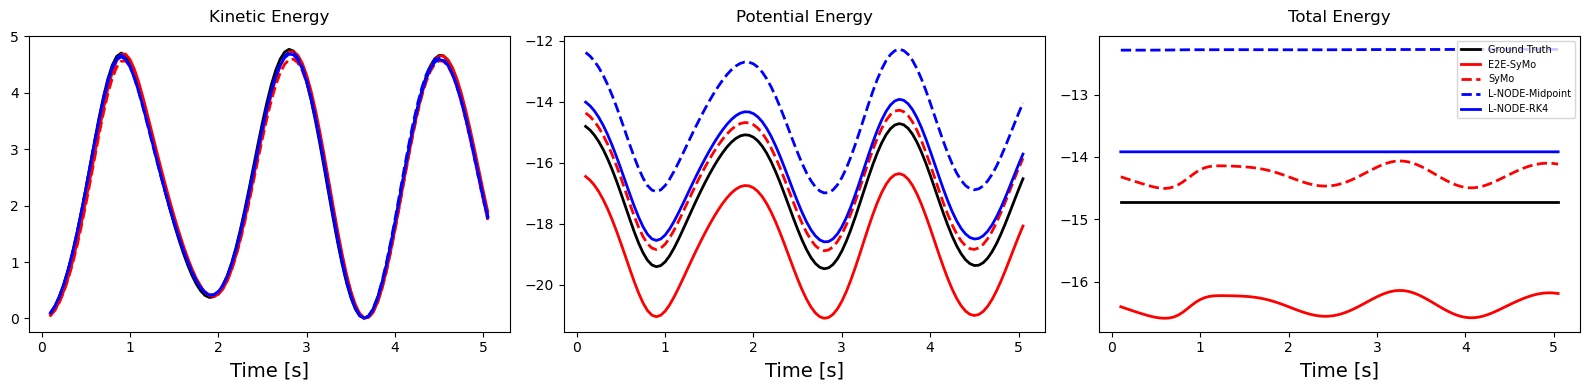

In [8]:
#%% Plot learned quantities
fig = plt.figure(figsize=(16, 4), dpi=DPI)
t_eval = t_eval[2:]
plt.subplot(1, 3, 1)

n=100
plt.plot(t_eval[:n], T_true[:n], 'k-', label='Ground Truth', linewidth=2)
plt.plot(t_eval[:n], T_learned_e2e_symo.cpu()[:n], 'r-', label='E2E-SyMo', linewidth=2)
plt.plot(t_eval[:n], T_learned_symo.cpu()[:n], 'r--', label='SyMo', linewidth=2)
plt.plot(t_eval[:n], T_learned_lode_midpoint.cpu()[:n], 'b--', label='L-NODE-Midpoint', linewidth=2)
plt.plot(t_eval[:n], T_learned_lode_rk4.cpu()[:n], 'b-', label='L-NODE-RK4', linewidth=2)
plt.title("Kinetic Energy", pad=10)
plt.xlabel("Time [s]", fontsize=14)

plt.subplot(1, 3, 2)
plt.plot(t_eval[:n], V_true[:n], 'k-', label='Ground Truth', linewidth=2)
plt.plot(t_eval[:n], V_learned_e2e_symo.cpu()[:n], 'r-', label='E2E-SyMo', linewidth=2)
plt.plot(t_eval[:n], V_learned_symo.cpu()[:n], 'r--', label='SyMo', linewidth=2)
plt.plot(t_eval[:n], V_learned_lode_midpoint.cpu()[:n], 'b--', label='L-NODE-Midpoint', linewidth=2)
plt.plot(t_eval[:n], V_learned_lode_rk4.cpu()[:n], 'b-', label='L-NODE-RK4', linewidth=2)
plt.title("Potential Energy", pad=10)
plt.xlabel("Time [s]", fontsize=14)

plt.subplot(1, 3, 3)
plt.plot(t_eval[:n], True_E[:n], 'k-', label='Ground Truth', linewidth=2)
plt.plot(t_eval[:n], E_learned_e2e_symo.cpu()[:n], 'r-', label='E2E-SyMo', linewidth=2)
plt.plot(t_eval[:n], E_learned_symo.cpu()[:n], 'r--', label='SyMo', linewidth=2)
plt.plot(t_eval[:n], E_learned_lode_midpoint.cpu()[:n], 'b--', label='L-NODE-Midpoint', linewidth=2)
plt.plot(t_eval[:n], E_learned_lode_rk4.cpu()[:n], 'b-', label='L-NODE-RK4', linewidth=2)
plt.title("Total Energy", pad=10)
plt.xlabel("Time [s]", fontsize=14)

fig.tight_layout()
plt.legend(fontsize=7)
plt.savefig('{}/Learned_quantities_acrobot'.format(args.fig_dir, 'png'))

## Observe Trajectories

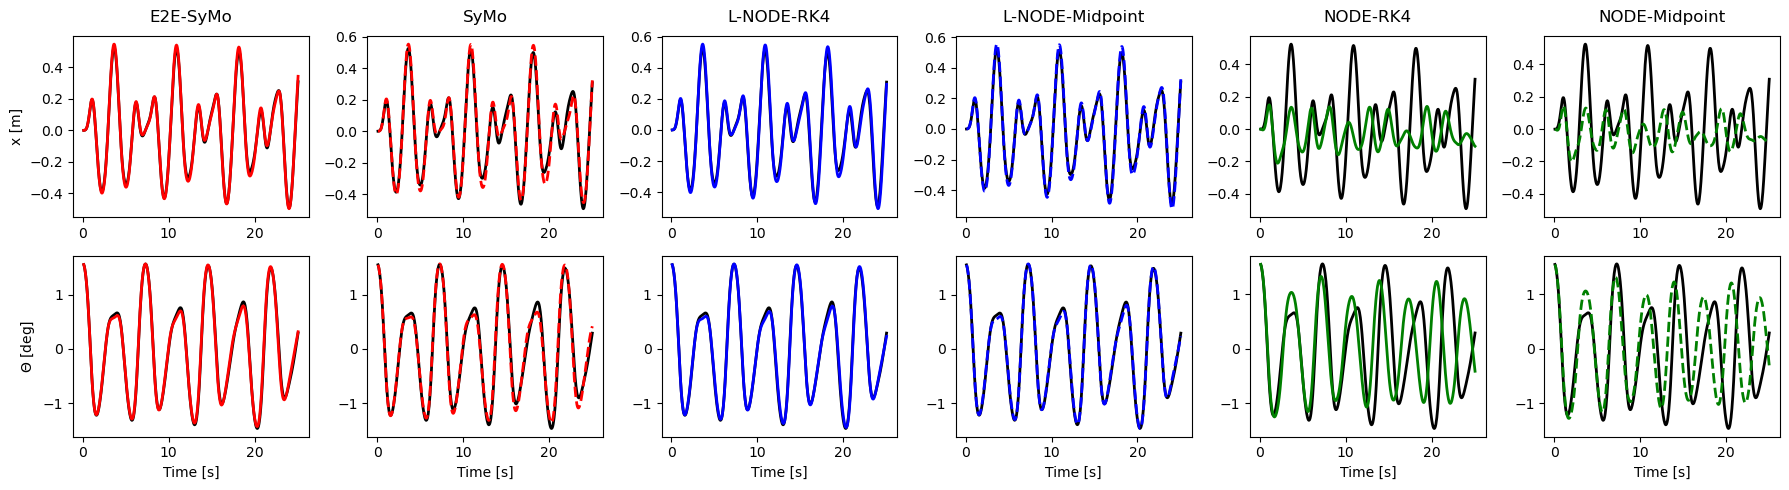

In [9]:
###
fig = plt.figure(figsize=(18, 5), dpi=DPI)
ax= plt.subplot(2,6,1)
plt.plot(t_eval, y_gt[:, 0], 'k-', label='Ground Truth', linewidth=2)
plt.plot(t_eval, y_pred_e2e_symo.cpu()[:, 0], 'r-', label='E2E-SyMo', linewidth=2)
plt.title("E2E-SyMo", pad=10)
plt.ylabel("x [m]")

ax= plt.subplot(2,6,2)
plt.plot(t_eval, y_gt[:, 0], 'k-', label='Ground Truth', linewidth=2)
plt.plot(t_eval, y_pred_symo.cpu()[:, 0], 'r--', label='SyMo', linewidth=2)
plt.title("SyMo", pad=10)

ax= plt.subplot(2,6,3)
plt.plot(t_eval, y_gt[:, 0], 'k-', label='Ground Truth', linewidth=2)
plt.plot(t_eval, y_pred_lode_rk4.cpu()[:, 0], 'b-', label='L-NODE-RK4', linewidth=2)
plt.title("L-NODE-RK4", pad=10)

ax= plt.subplot(2,6,4)
plt.plot(t_eval, y_gt[:, 0], 'k-', label='Ground Truth', linewidth=2)
plt.plot(t_eval, y_pred_lode_midpoint.cpu()[:, 0], 'b--', label='L-NODE-Midpoint', linewidth=2)
plt.title("L-NODE-Midpoint", pad=10)

ax= plt.subplot(2,6,5)
plt.plot(t_eval, y_gt[:, 0], 'k-', label='Ground Truth', linewidth=2)
plt.plot(t_eval, y_pred_node_rk4.cpu()[:, 0], 'g-', label='NODE-RK4', linewidth=2)
plt.title("NODE-RK4", pad=10)

ax= plt.subplot(2,6,6)
plt.plot(t_eval, y_gt[:, 0], 'k-', label='Ground Truth', linewidth=2)
plt.plot(t_eval, y_pred_node_midpoint[:, 0].cpu(), 'g--', label='NODE-Midpoint', linewidth=2)
plt.title("NODE-Midpoint", pad=10)

ax= plt.subplot(2,6,7)
plt.plot(t_eval, y_gt[:, 1], 'k-', label='Ground Truth', linewidth=2)
plt.plot(t_eval, y_pred_e2e_symo.cpu()[:, 1], 'r-', label='E2E-SyMo', linewidth=2)
plt.xlabel("Time [s]")
plt.ylabel(r"$\Theta$ [deg]")

ax= plt.subplot(2,6,8)
plt.plot(t_eval, y_gt[:, 1], 'k-', label='Ground Truth', linewidth=2)
plt.plot(t_eval, y_pred_symo.cpu()[:, 1], 'r--', label='SyMo', linewidth=2)
plt.xlabel("Time [s]")

ax= plt.subplot(2,6,9)
plt.plot(t_eval, y_gt[:, 1], 'k-', label='Ground Truth', linewidth=2)
plt.plot(t_eval, y_pred_lode_rk4.cpu()[:, 1], 'b-', label='L-NODE-RK4', linewidth=2)
plt.xlabel("Time [s]")

ax= plt.subplot(2,6,10)
plt.plot(t_eval, y_gt[:, 1], 'k-', label='Ground Truth', linewidth=2)
plt.plot(t_eval, y_pred_lode_midpoint.cpu()[:, 1], 'b--', label='L-NODE-Midpoint', linewidth=2)
plt.xlabel("Time [s]")

ax= plt.subplot(2,6,11)
plt.plot(t_eval, y_gt[:, 1], 'k-', label='Ground Truth', linewidth=2)
plt.plot(t_eval, y_pred_node_rk4.cpu()[:, 1], 'g-', label='NODE-RK4', linewidth=2)
plt.xlabel("Time [s]")

ax= plt.subplot(2,6,12)
plt.plot(t_eval, y_gt[:, 1], 'k-', label='Ground Truth', linewidth=2)
plt.plot(t_eval, y_pred_node_midpoint[:, 1].cpu(), 'g--', label='NODE-Midpoint', linewidth=2)
plt.xlabel("Time [s]")

fig.tight_layout()
plt.savefig('{}/trajectories_acrobot'.format(args.fig_dir, 'png'))

## Plot trajectory energies and MSE

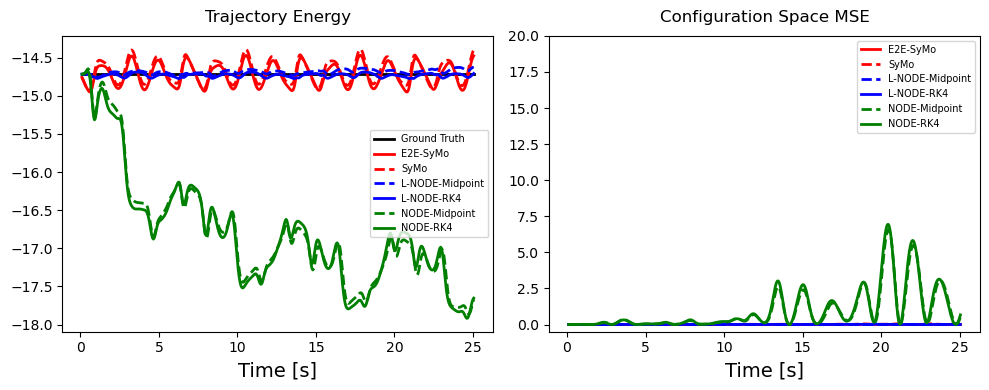

In [10]:
#Energies
E_node_midpoint = acrobot().energy(y_pred_node_midpoint.cpu())
E_node_rk4 = acrobot().energy(y_pred_node_rk4.cpu())
E_lode_midpoint = acrobot().energy(y_pred_lode_midpoint.cpu())
E_lode_rk4 = acrobot().energy(y_pred_lode_rk4.cpu())
E_symo = acrobot().energy(y_pred_symo.cpu())
E_e2e_symo = acrobot().energy(y_pred_e2e_symo.cpu())

T_node_midpoint = acrobot().kinetic_energy(y_pred_node_midpoint.cpu())
T_node_rk4 = acrobot().kinetic_energy(y_pred_node_rk4.cpu())
T_lode_midpoint = acrobot().kinetic_energy(y_pred_lode_midpoint.cpu())
T_lode_rk4 = acrobot().kinetic_energy(y_pred_lode_rk4.cpu())
T_symo = acrobot().kinetic_energy(y_pred_symo.cpu())
T_e2e_symo = acrobot().kinetic_energy(y_pred_e2e_symo.cpu())

V_node_midpoint = acrobot().potential_energy(y_pred_node_midpoint.cpu())
V_node_rk4 = acrobot().potential_energy(y_pred_node_rk4.cpu())
V_lode_midpoint = acrobot().potential_energy(y_pred_lode_midpoint.cpu())
V_lode_rk4 = acrobot().potential_energy(y_pred_lode_rk4.cpu())
V_symo = acrobot().potential_energy(y_pred_symo.cpu())
V_e2e_symo = acrobot().potential_energy(y_pred_e2e_symo.cpu())

#MSE between configurations
MSE_node_midpoint = torch.sum((y_gt[:, :2] - y_pred_node_midpoint[:, :2].cpu())**2, 1)
MSE_node_rk4 = torch.sum((y_gt[:, :2] - y_pred_node_rk4[:, :2].cpu())**2, 1)
MSE_lode_midpoint = torch.sum((y_gt[:, :2] - y_pred_lode_midpoint[:, :2].cpu())**2, 1)
MSE_lode_rk4 = torch.sum((y_gt[:, :2] - y_pred_lode_rk4[:, :2].cpu())**2, 1)
MSE_symo = torch.sum((y_gt[:, :2] - y_pred_symo[:, :2].cpu())**2, 1)
MSE_e2e_symo = torch.sum((y_gt[:, :2] - y_pred_e2e_symo[:, :2].cpu())**2, 1)

fig = plt.figure(figsize=(10, 4), dpi=DPI)
n=500
ax= plt.subplot(1,2,1)
plt.plot(t_eval[:n], True_E[:n], 'k-', label='Ground Truth', linewidth=2)
plt.plot(t_eval[:n], E_e2e_symo[:n], 'r-', label='E2E-SyMo', linewidth=2)
plt.plot(t_eval[:n], E_symo[:n], 'r--', label='SyMo', linewidth=2)
plt.plot(t_eval[:n], E_lode_midpoint[:n], 'b--', label='L-NODE-Midpoint', linewidth=2)
plt.plot(t_eval[:n], E_lode_rk4[:n], 'b-', label='L-NODE-RK4', linewidth=2)
plt.plot(t_eval[:n], E_node_midpoint[:n], 'g--', label='NODE-Midpoint', linewidth=2)
plt.plot(t_eval[:n], E_node_rk4[:n], 'g-', label='NODE-RK4', linewidth=2)
plt.title("Trajectory Energy", pad=10)
plt.xlabel("Time [s]", fontsize=14)
plt.legend(fontsize=7)

ax=plt.subplot(1,2,2)

plt.plot(t_eval[:n], MSE_e2e_symo[:n], 'r-', label='E2E-SyMo', linewidth=2)
plt.plot(t_eval[:n], MSE_symo[:n], 'r--', label='SyMo', linewidth=2)
plt.plot(t_eval[:n], MSE_lode_midpoint[:n], 'b--', label='L-NODE-Midpoint', linewidth=2)
plt.plot(t_eval[:n], MSE_lode_rk4[:n], 'b-', label='L-NODE-RK4', linewidth=2)
plt.plot(t_eval[:n], MSE_node_midpoint[:n], 'g--', label='NODE-Midpoint', linewidth=2)
plt.plot(t_eval[:n], MSE_node_rk4[:n], 'g-', label='NODE-RK4', linewidth=2)
plt.title("Configuration Space MSE", pad=10)
plt.xlabel("Time [s]", fontsize=14)
plt.ylim(-0.5, 20)
plt.legend(fontsize=7)

fig.tight_layout()
plt.savefig('{}/E_MSE_acrobot'.format(args.fig_dir, 'png'))

## Forced Integration


In [11]:
#%% Integrate models with forces
x0 = [np.pi/4, np.pi/4, 0, 0] 

h=args_symo.time_step #all models were trained under the same time_step
N=100
t_eval1 = np.linspace(0, (N+1)*h , N+2)
T = 10
u = np.sin(2*np.pi*t_eval1/T)
import gym 
import Code.myenv
#get ground truth
env = gym.make('MyAcrobot-v0')
env.dt = h
env.reset()
env.state = np.array(x0, dtype=np.float32)
obs_list = []
obs_list.append(env.state)

for i in range(len(t_eval1)-1):
    obs, _, _, _ = env.step([u[i]])
    obs_list.append(obs)
traj_forced = np.stack(obs_list)

x0_odes_forced = torch.tensor(traj_forced[1]).float().to(device)
x0_symos_forced = torch.tensor(traj_forced[:2, :2].flatten()).float().to(device)

u_zeros=np.zeros_like(u)
u=np.stack((u, u_zeros),1)

y_pred_node_midpoint_forced = integrate_ODE(nn_node_rk2, "midpoint", x0_odes_forced, N, h, device, u[1:-1])
y_pred_node_rk4_forced = integrate_ODE(nn_node_rk4, "rk4", x0_odes_forced, N, h, device, u[1:-1])
y_pred_lode_midpoint_forced = integrate_ODE(nn_lode_rk2, "midpoint", x0_odes_forced, N, h, device, u[1:-1])
y_pred_lode_rk4_forced = integrate_ODE(nn_lode_rk4, "rk4", x0_odes_forced, N, h, device, u[1:-1])

#Integrate models symos
y_pred_symo_forced = implicit_integration_DEL(args_symo.root_find, N, h, nn_symo, x0_symos_forced, args.pred_tol, args.pred_maxiter, device, us = u)
y_pred_e2e_symo_forced = implicit_integration_DEL(args_e2e_symo.root_find, N, h, nn_e2e_symo, x0_symos_forced, args.pred_tol, args.pred_maxiter, device, us = u)

H_forced_lode_midpoint, V_learned_lode_midpoint, T_learned_lode_midpoint = nn_lode_rk2.get_matrices(y_pred_lode_midpoint_forced) 
H_forced_lode_rk4, V_learned_lode_rk4, T_learned_lode_rk4 = nn_lode_rk4.get_matrices(y_pred_lode_rk4_forced) 
H_forced_symo, V_learned_symo, T_learned_symo = nn_symo.get_matrices(y_pred_symo_forced) 
H_forced_e2e_symo, V_learned_e2e_symo, T_learned_e2e_symo = nn_e2e_symo.get_matrices(y_pred_e2e_symo_forced) 

y_pred_node_midpoint_forced = y_pred_node_midpoint_forced .cpu().numpy()
y_pred_node_rk4_forced = y_pred_node_rk4_forced.cpu().numpy()
y_pred_lode_midpoint_forced = y_pred_lode_midpoint_forced.cpu().numpy()
y_pred_lode_rk4_forced = y_pred_lode_rk4_forced.cpu().numpy()
y_pred_symo_forced = y_pred_symo_forced.cpu().numpy()
y_pred_e2e_symo_forced = y_pred_e2e_symo_forced.cpu().numpy()

y_true_forced = traj_forced[2:]
#MSE between configurations
MSE_node_midpoint_forced = np.sum((y_true_forced[:, :2] - y_pred_node_midpoint_forced[:, :2])**2, 1)
MSE_node_rk4_forced = np.sum((y_true_forced[:,:2] - y_pred_node_rk4_forced[:, :2])**2, 1)
MSE_lode_midpoint_forced = np.sum((y_true_forced[:, :2] - y_pred_lode_midpoint_forced[:, :2])**2, 1)
MSE_lode_rk4_forced = np.sum((y_true_forced[:, :2] - y_pred_lode_rk4_forced[:, :2])**2, 1)
MSE_symo_forced = np.sum((y_true_forced[:, :2] - y_pred_symo_forced[:, :2])**2, 1)
MSE_e2e_symo_forced = np.sum((y_true_forced[:, :2] - y_pred_e2e_symo_forced[:, :2])**2, 1)

True_E_forced = acrobot().energy(y_true_forced)
E_node_midpoint_forced = acrobot().energy(y_pred_node_midpoint_forced)
E_node_rk4_forced = acrobot().energy(y_pred_node_rk4_forced)
E_lode_midpoint_forced = acrobot().energy(y_pred_lode_midpoint_forced)
E_lode_rk4_forced = acrobot().energy(y_pred_lode_rk4_forced)
E_symo_forced = acrobot().energy(y_pred_symo_forced)
E_e2e_symo_forced = acrobot().energy(y_pred_e2e_symo_forced)

MSE_E_e2e_symo = (True_E_forced - E_e2e_symo_forced)**2 
MSE_E_symo = (True_E_forced - E_symo_forced)**2
MSE_E_lode_midpoint = (True_E_forced - E_lode_midpoint_forced)**2
MSE_E_lode_rk4 = (True_E_forced - E_lode_rk4_forced)**2
MSE_E_node_midpoint = (True_E_forced - E_node_midpoint_forced)**2
MSE_E_node_rk4 = (True_E_forced - E_node_rk4_forced)**2



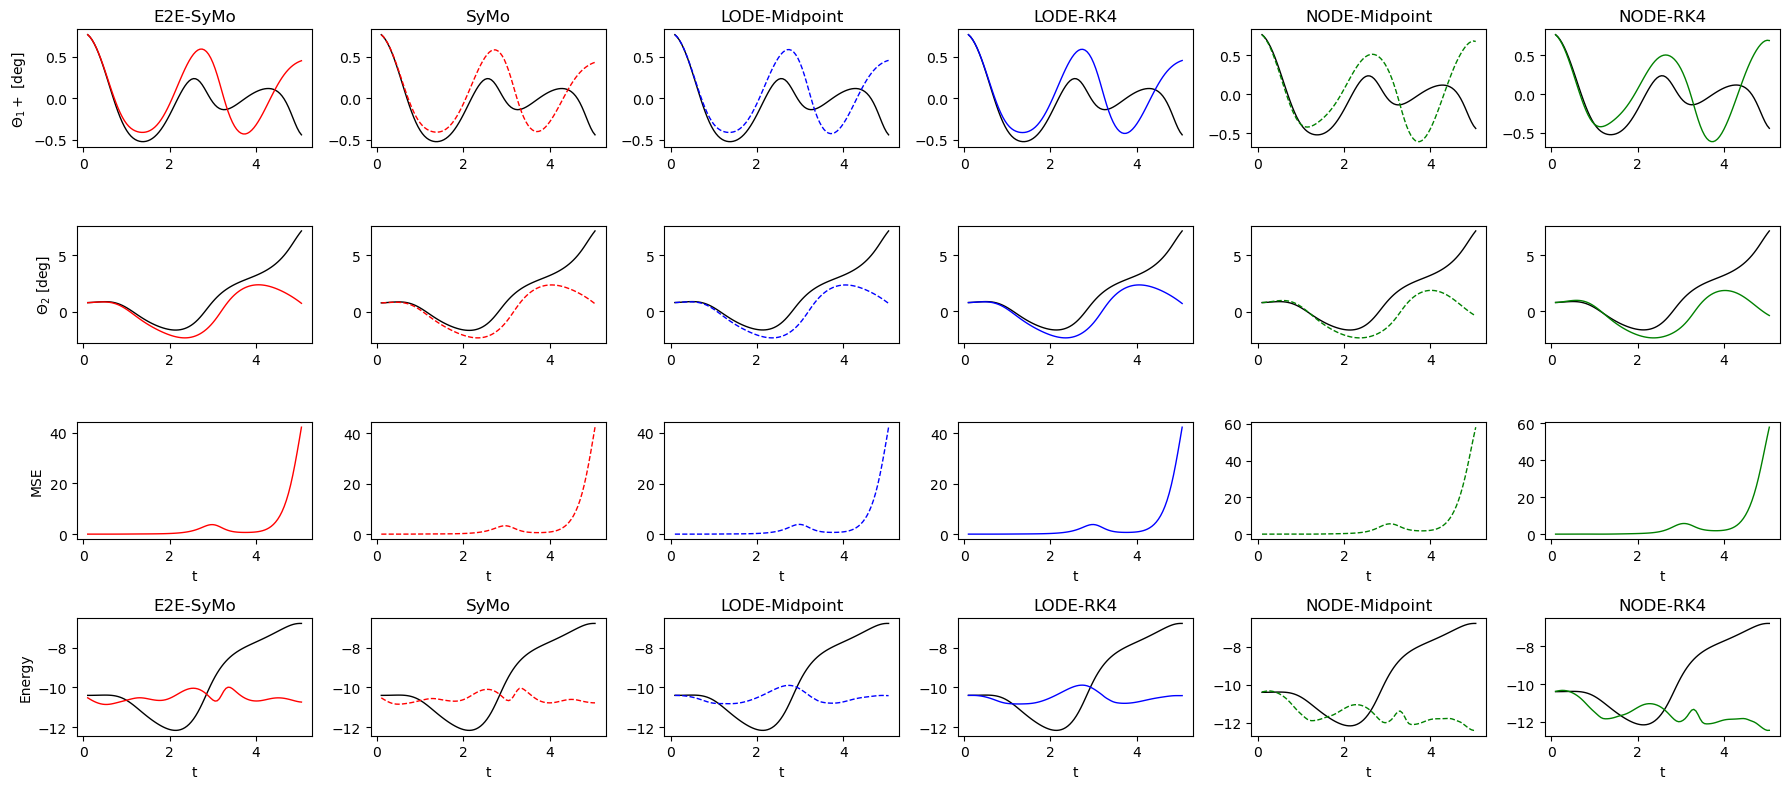

In [12]:
# %% plot forced results
from matplotlib import gridspec
t_eval = t_eval1[2:]
fig = plt.figure(figsize=(18, 8), dpi=DPI)
gs = gridspec.GridSpec(4, 6) 

plt.subplot(gs[0])
plt.plot(t_eval, y_true_forced[:, 0], 'k-', label='Ground Truth', linewidth=1)
plt.plot(t_eval, y_pred_e2e_symo_forced[:, 0], 'r-', label='E2E-SyMo', linewidth=1)
plt.ylabel(r"$\Theta_1+$ [deg]")
plt.title('E2E-SyMo')

plt.subplot(gs[1])
plt.plot(t_eval, y_true_forced[:, 0], 'k-', label='Ground Truth', linewidth=1)
plt.plot(t_eval, y_pred_symo_forced[:, 0], 'r--', label='SyMo', linewidth=1)
plt.title('SyMo')

plt.subplot(gs[2])
plt.plot(t_eval, y_true_forced[:, 0], 'k-', label='Ground Truth', linewidth=1)
plt.plot(t_eval, y_pred_lode_midpoint_forced[:, 0], 'b--', label='L-NODE-Midpoint', linewidth=1)

plt.title('LODE-Midpoint')

plt.subplot(gs[3])
plt.plot(t_eval, y_true_forced[:, 0], 'k-', label='Ground Truth', linewidth=1)
plt.plot(t_eval, y_pred_lode_rk4_forced[:, 0], 'b-', label='L-NODE-RK4', linewidth=1)

plt.title('LODE-RK4')

plt.subplot(gs[4])
plt.plot(t_eval, y_true_forced[:, 0], 'k-', label='Ground Truth', linewidth=1)
plt.plot(t_eval, y_pred_node_midpoint_forced[:, 0], 'g--', label='NODE-Midpoint', linewidth=1)
plt.title('NODE-Midpoint')

plt.subplot(gs[5])
plt.plot(t_eval, y_true_forced[:, 0], 'k-', label='Ground Truth', linewidth=1)
plt.plot(t_eval, y_pred_node_rk4_forced[:, 0], 'g-', label='NODE-RK4', linewidth=1)
plt.title('NODE-RK4')

plt.subplot(gs[6])
plt.plot(t_eval, y_true_forced[:, 1], 'k-', label='Ground Truth', linewidth=1)
plt.plot(t_eval, y_pred_e2e_symo_forced[:, 1], 'r-', label='E2E-SyMo', linewidth=1)
plt.ylabel(r"$\Theta_2$ [deg]")

plt.subplot(gs[7])
plt.plot(t_eval, y_true_forced[:, 1], 'k-', label='Ground Truth', linewidth=1)
plt.plot(t_eval, y_pred_symo_forced[:, 1], 'r--', label='SyMo', linewidth=1)

plt.subplot(gs[8])
plt.plot(t_eval, y_true_forced[:, 1], 'k-', label='Ground Truth', linewidth=1)
plt.plot(t_eval, y_pred_lode_midpoint_forced[:, 1], 'b--', label='L-NODE-Midpoint', linewidth=1)


plt.subplot(gs[9])
plt.plot(t_eval, y_true_forced[:, 1], 'k-', label='Ground Truth', linewidth=1)
plt.plot(t_eval, y_pred_lode_rk4_forced[:, 1], 'b-', label='L-NODE-RK4', linewidth=1)


plt.subplot(gs[10])
plt.plot(t_eval, y_true_forced[:, 1], 'k-', label='Ground Truth', linewidth=1)
plt.plot(t_eval, y_pred_node_midpoint_forced[:, 1], 'g--', label='NODE-Midpoint', linewidth=1)

plt.subplot(gs[11])
plt.plot(t_eval, y_true_forced[:, 1], 'k-', label='Ground Truth', linewidth=1)
plt.plot(t_eval, y_pred_node_rk4_forced[:, 1], 'g-', label='NODE-RK4', linewidth=1)

# Second axes
plt.subplot(gs[12])
ax1=plt.plot(t_eval, MSE_e2e_symo_forced, 'r-', label='E2E-SyMo', linewidth=1)
plt.xlabel('t')
plt.ylabel('MSE')

plt.subplot(gs[13])
ax2=plt.plot(t_eval, MSE_symo_forced, 'r--', label='SyMo', linewidth=1)
plt.xlabel('t')

plt.subplot(gs[14])
ax3=plt.plot(t_eval, MSE_lode_midpoint_forced, 'b--', label='L-NODE-Midpoint', linewidth=1)
plt.xlabel('t')

plt.subplot(gs[15])
ax4=plt.plot(t_eval, MSE_lode_rk4_forced, 'b-', label='L-NODE-RK4', linewidth=1)
plt.xlabel('t')

plt.subplot(gs[16])
ax5=plt.plot(t_eval, MSE_node_midpoint_forced, 'g--', label='NODE-Midpoint', linewidth=1)
plt.xlabel('t')

plt.subplot(gs[17])
ax6=plt.plot(t_eval, MSE_node_rk4_forced, 'g-', label='NODE-RK4', linewidth=1)
plt.xlabel('t')

plt.subplot(gs[18])
plt.plot(t_eval, True_E_forced, 'k-', label='Ground Truth', linewidth=1)
ax1=plt.plot(t_eval, E_e2e_symo_forced, 'r-', label='E2E-SyMo', linewidth=1)
plt.xlabel('t')
plt.ylabel('Energy')
plt.title('E2E-SyMo')

plt.subplot(gs[19])
plt.plot(t_eval, True_E_forced, 'k-', label='Ground Truth', linewidth=1)
ax2=plt.plot(t_eval, E_symo_forced, 'r--', label='SyMo', linewidth=1)
plt.xlabel('t')
plt.title('SyMo')

plt.subplot(gs[20])
plt.plot(t_eval, True_E_forced, 'k-', label='Ground Truth', linewidth=1)
ax3=plt.plot(t_eval, E_lode_midpoint_forced, 'b--', label='L-NODE-Midpoint', linewidth=1)
plt.xlabel('t')
plt.title('LODE-Midpoint')

plt.subplot(gs[21])
plt.plot(t_eval, True_E_forced, 'k-', label='Ground Truth', linewidth=1)
ax4=plt.plot(t_eval, E_lode_rk4_forced, 'b-', label='L-NODE-RK4', linewidth=1)
plt.xlabel('t')
plt.title('LODE-RK4')

plt.subplot(gs[22])
plt.plot(t_eval, True_E_forced, 'k-', label='Ground Truth', linewidth=1)
ax5=plt.plot(t_eval, E_node_midpoint_forced, 'g--', label='NODE-Midpoint', linewidth=1)
plt.xlabel('t')
plt.title('NODE-Midpoint')

plt.subplot(gs[23])
plt.plot(t_eval, True_E_forced, 'k-', label='Ground Truth', linewidth=1)
ax6=plt.plot(t_eval, E_node_rk4_forced, 'g-', label='NODE-RK4', linewidth=1)
plt.xlabel('t')
plt.title('NODE-RK4')

fig.tight_layout()
plt.savefig('{}/traj_forced_acrobot'.format(args.fig_dir, 'png'))